# Import Dependencies

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Preprocess Data

## Import Raw Data and Perform Basic Data Cleaning

The idea behind this project is to determine the category of a Kepler object of interest based on observed values. "Koi_pdisposition" and "koi_score" are derived from the data and related to "koi_disposition," which is the target; therefore, I will drop these columns.

The following columns are simply multiple ways of referring to the same objects of interest: "kepid," "kepoi_name," "kepler_name." As these will not be used as features, I will drop them.

"Koi_tce_delivname" is a unique string label corresponding to TCE data and will also be dropped.

In [3]:
# Import data
df = pd.read_csv(os.path.join("Resources", "cumulative.csv"))

### Drop columns that will not be used in model

* The idea behind this project is to determine the category of a Kepler object of interest based on observed values. "Koi_pdisposition" and "koi_score" are derived from the data and related to "koi_disposition," which is the target; therefore, I will drop these columns.
* The following columns are simply multiple ways of referring to the same objects of interest: "kepid," "kepoi_name," "kepler_name." As these will not be used as features, I will drop them.
* "Koi_tce_delivname" is a unique string label corresponding to TCE data and will also be dropped.
* All of the columns tagged w/ err indicate uncertainty in the corresponding measurement. As the measurements in and of themselves can not be used in a model, as the are related to other measurements, the options are to perform some calculation on these data, creating new features, or dropping the columns. I have decided to drop the columns and will include that in my assumptions for this model.

In [4]:
# Drop columns that will not be used in model
df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", \
                      "koi_pdisposition", "koi_score", "koi_tce_delivname"],\
       inplace = True)

err_list = [column for column in df.columns if "err" in column]

df.drop(columns = err_list, inplace = True)

# Preview Data
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,...,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,...,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,...,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,175.850252,0.969,1.78220,10829.0,...,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,...,1395.0,891.96,505.6,1.0,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,...,1406.0,926.16,40.9,1.0,6031.0,4.438,1.046,288.75488,48.226200,15.509


### Verify data are of the correct type

In [5]:
print(f"Data types: \n{df.dtypes}")

Data types: 
koi_disposition      object
koi_fpflag_nt         int64
koi_fpflag_ss         int64
koi_fpflag_co         int64
koi_fpflag_ec         int64
koi_period          float64
koi_time0bk         float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_prad            float64
koi_teq             float64
koi_insol           float64
koi_model_snr       float64
koi_tce_plnt_num    float64
koi_steff           float64
koi_slogg           float64
koi_srad            float64
ra                  float64
dec                 float64
koi_kepmag          float64
dtype: object


#### Verify values "make sense" for for non-float columns

In [6]:
# Disposition will be our target. It is a discrete list of strings
print(f"Disposition: {df.koi_disposition.unique()}\n")

Disposition: ['CONFIRMED' 'FALSE POSITIVE' 'CANDIDATE']



In [7]:
# All of the fpflag values are bools indicating certain properties
print(f"flag1: {df.koi_fpflag_nt.unique()}\n")
print(f"flag2: {df.koi_fpflag_ss.unique()}\n")
print(f"flag3: {df.koi_fpflag_co.unique()}\n")
print(f"flag4: {df.koi_fpflag_ec.unique()}\n")

flag1: [0 1]

flag2: [0 1]

flag3: [0 1]

flag4: [0 1]



### Manage missing data

In [8]:
# Display columns with missing data
print(f"Number of rows: {len(df)}")
print(f"Missing data:  \n{df.isnull().sum()}")

Number of rows: 9564
Missing data:  
koi_disposition       0
koi_fpflag_nt         0
koi_fpflag_ss         0
koi_fpflag_co         0
koi_fpflag_ec         0
koi_period            0
koi_time0bk           0
koi_impact          363
koi_duration          0
koi_depth           363
koi_prad            363
koi_teq             363
koi_insol           321
koi_model_snr       363
koi_tce_plnt_num    346
koi_steff           363
koi_slogg           363
koi_srad            363
ra                    0
dec                   0
koi_kepmag            1
dtype: int64


There is not an insignificant number of missing values. Must decide whether to remove the data or replace. As I do not want to lose data that could be valuable in the model, I will inpute the data using knn, which tends to be more accurate than many other inputation methods. Its biggest drawback is that it is computationally expensive; however, as this dataset is relatively small, this should not be an issue.

In [10]:
# Split into X and y
y = df["koi_disposition"]
X = df.drop(columns = "koi_disposition")
cols = X.columns

#Impute values using KNN
imputer = KNNImputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = cols)

## Feature Selection

In [11]:
# Get basic statistics on the data
X.describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
count,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9.564000e+03,9564.000000,9564.000000,9.564000e+03,9564.00000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000
mean,0.188206,0.231598,0.194898,0.120033,75.671358,166.183251,0.739376,5.621606,2.344407e+04,106.634937,1077.027415,7.723274e+03,256.66207,1.247972,5706.302656,4.307946,1.742346,292.060163,43.810433,14.264669
std,0.390897,0.421875,0.396143,0.325018,1334.744046,67.918960,3.307982,6.471554,8.091212e+04,3045.420434,856.892902,1.573127e+05,783.06415,0.660116,785.540605,0.428863,6.051975,4.766657,3.601243,1.385389
min,0.000000,0.000000,0.000000,0.000000,0.241843,120.515914,0.000000,0.052000,0.000000e+00,0.080000,25.000000,0.000000e+00,0.00000,1.000000,2661.000000,0.047000,0.109000,279.852720,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,2.733684,132.761718,0.207000,2.437750,1.659750e+02,1.430000,528.000000,1.876250e+01,12.10000,1.000000,5320.000000,4.212000,0.833000,288.660770,40.777173,13.440000
50%,0.000000,0.000000,0.000000,0.000000,9.752831,137.224595,0.537000,3.792600,4.410000e+02,2.450000,864.000000,1.326200e+02,23.50000,1.000000,5763.000000,4.438000,1.000000,292.261125,43.677504,14.520000
75%,0.000000,0.000000,0.000000,0.000000,40.715178,170.694603,0.880000,6.276500,1.624950e+03,15.365000,1372.000000,8.369125e+02,81.72500,1.000000,6106.000000,4.540000,1.359000,295.859160,46.714611,15.322000
max,1.000000,1.000000,1.000000,1.000000,129995.778400,1472.522306,100.806000,138.540000,1.541400e+06,200346.000000,14667.000000,1.094755e+07,9054.70000,8.000000,15896.000000,5.364000,229.908000,301.720760,52.336010,20.003000


### Check data distribution and outliers

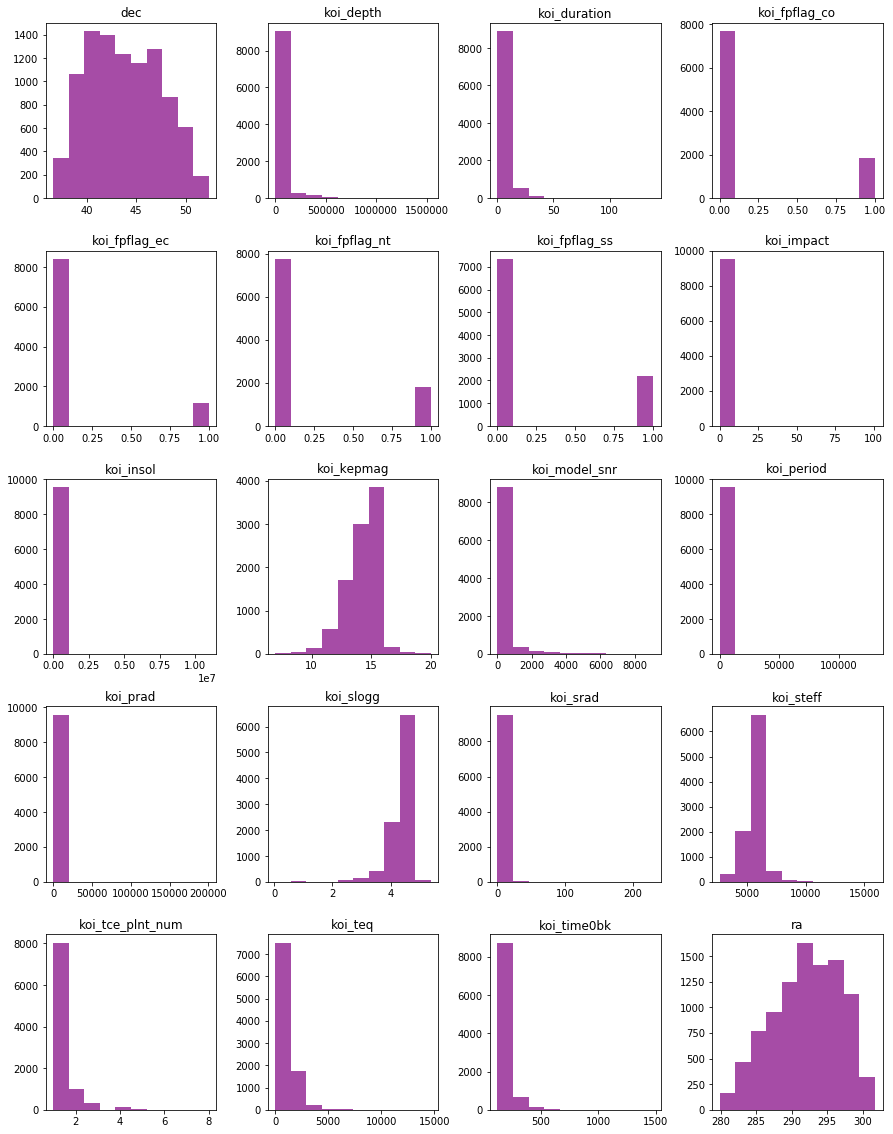

In [12]:
X.hist(figsize=(15,20), color="purple",alpha=0.7, grid=False);

From above, we can see that there is very skewed distribution on some features, some of which are definitely caused by outliers. For example, the "koi_period" has 75% of the data <= 40.7, with a max of 130,000 and a standard deviation of 1334. This can be visualized with boxplots below.

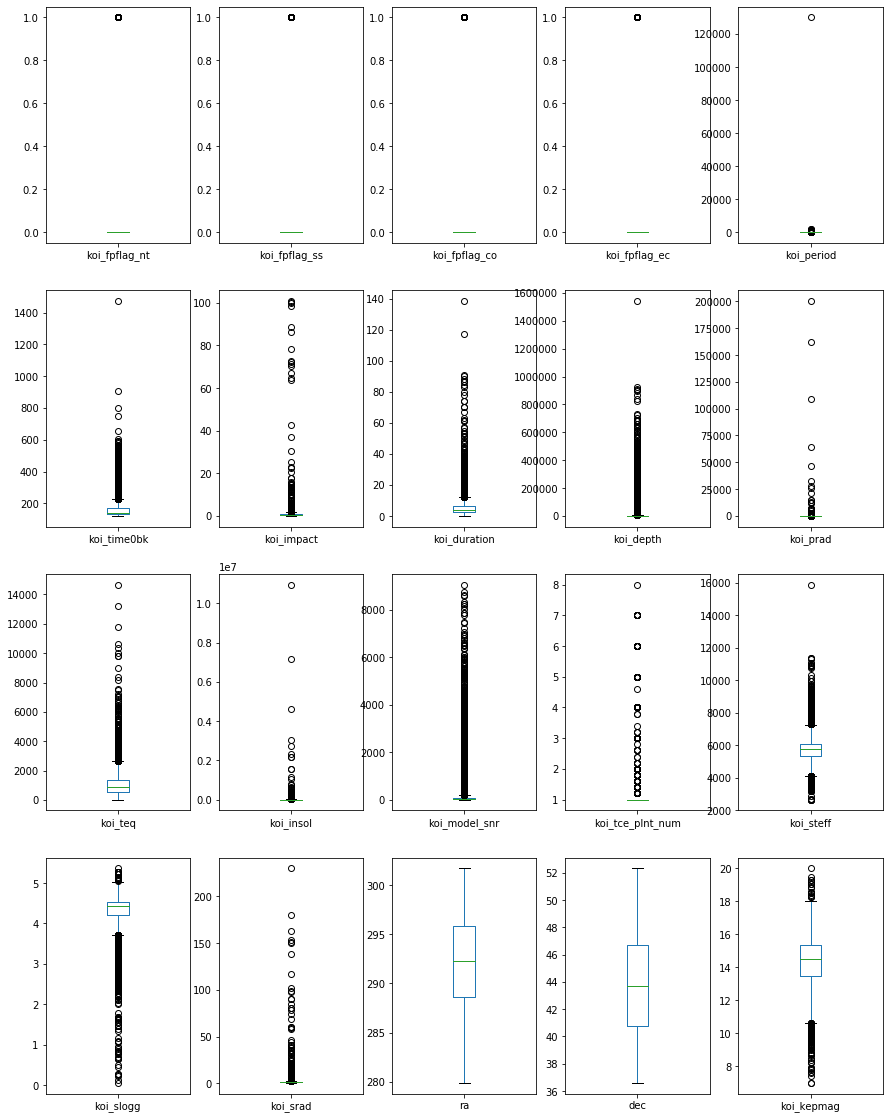

In [13]:
X.plot(figsize=(15,20), kind='box', subplots=True, layout=(4,5), sharex=False, sharey=False)
plt.show()

From the boxplots we can see that most features have a not insignificant number of outliers. For this reason, we must be mindful of removing or replacing them. For now, I will leave the outliers as is and later consider managing them when choosing a model.

### Feature importance

There are various methods of determining feature importance. Here, I will use two model-based approaches--using KNN and Extra-Tree classifiers.

In [14]:
# Find top features using SelectKBest
KBest = SelectKBest(score_func = chi2, k = 10).fit(X,y)
scores_df = pd.DataFrame({"Feature": X.columns, "Score": KBest.scores_})
scores_df.nlargest(10, "Score")

,Feature,Score
8,koi_depth,1.755240e+08
11,koi_insol,3.083127e+07
12,koi_model_snr,1.193645e+06
9,koi_prad,6.681905e+05
10,koi_teq,3.858102e+05
4,koi_period,1.613493e+05
14,koi_steff,3.825586e+04
1,koi_fpflag_ss,1.787714e+03
7,koi_duration,1.770015e+03
2,koi_fpflag_co,1.662402e+03


In [15]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier().fit(X,y)
tree_scores_df = pd.DataFrame({"feature": X.columns, "Importance": model.feature_importances_})
tree_scores_df.nlargest(10, "Importance")

,feature,Importance
0,koi_fpflag_nt,0.181606
1,koi_fpflag_ss,0.161789
2,koi_fpflag_co,0.121307
12,koi_model_snr,0.068825
3,koi_fpflag_ec,0.051308
8,koi_depth,0.042801
5,koi_time0bk,0.033130
9,koi_prad,0.032745
7,koi_duration,0.030752
4,koi_period,0.030582


I will choose the top 3 from each list and then any other feature that occurs on both lists.

In [16]:
X = X[["koi_fpflag_nt", "koi_fpflag_ss","koi_fpflag_co", "koi_depth",\
       "koi_insol", "koi_model_snr", "koi_teq", "koi_prad", "koi_duration"]]

## Create a Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale data

Using the MinMaxScaler

In [18]:
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create Machine Learning Models

## Support Vector Machine

In [ ]:
model = SVC(gamma="auto")
model.fit(X_train_scaled, y_train)
svm_score = model.score(X_test_scaled, y_test)

print(f"The SVM classifier score is {svm_score}".)

## SVM with Hyperparameter Tuning

In [ ]:
param_grid = {'C': [1, 5, 10],
              'gamma': [0.0001, 0.001, 0.01]}
grid = GridSearchCV(model, param_grid, verbose=3, cv=3)
grid.fit(X_train_scaled, y_train)

In [ ]:
# Find the best parameters based on gridsearch
print(f"The best parameters for SVM are: {grid.best_params_}")

In [ ]:
# Find the score for the best parameters
model = SVC(C=10, gamma=0.01)
model.fit(X_train_scaled, y_train)
grid_svm_score = model.score(X_test_scaled, y_test)
print(f"The score for the best SVM model is: {grid_svm_score}")

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

## KNN Classifier

In [ ]:
# Loop through different k values to see which has the highest accuracy
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

### Determine score for k with best accuracy

In [ ]:
# Note that k: 15 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
print('k15 Test Acc: %.3f' % knn.score(X_test, y_test))

# Determine best classifier 

In [ ]:
# SVM
print(f"SVM Score: {svm_score}")

# SVM with Gridsearch
print(f"SVM gridsearch best score: {grid_svm_score}")

# Random Forest
print(f"Random Forest Score: {rf.score(X_test_scaled, y_test)}")

# KNN
print('KNN Test Acc: %.3f' % knn.score(X_test, y_test))

# Random Forest is best classifier